In [33]:
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score

In [8]:
root_path = "data/types.csv"
df = pd.read_csv(root_path)
df.drop(columns=['Unnamed: 1'], inplace=True)
df.head()

,review_text,type
0,We had a wonderful Saturday night dinner.,4
1,They had a fire dancer by the beach and a musi...,3
2,The seafood grill was good and their buttered ...,1
3,The grilled lamb was very chewy and not edible...,1
4,the service was good for a packed restaurant,2


In [9]:
df.dropna()

,review_text,type
0,We had a wonderful Saturday night dinner.,4
1,They had a fire dancer by the beach and a musi...,3
2,The seafood grill was good and their buttered ...,1
3,The grilled lamb was very chewy and not edible...,1
4,the service was good for a packed restaurant,2
...,...,...
495,but the mixed grill was really bad.,1
496,Half of the meat was gizzard and chicken liver...,1
497,told our waiter about the vegetables and to pa...,2
498,You guys should have a much better mixed grill,1


In [10]:
df.shape

(500, 2)

In [13]:
train, test = train_test_split(df, test_size=0.15)


In [14]:
print("training dataset size", train.shape)
print("testing dataset size", test.shape)

training dataset size (425, 2)
testing dataset size (75, 2)


c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


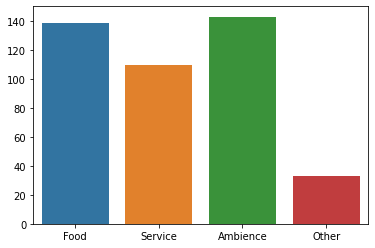

In [17]:
food_count = len(train[train.type == 1])
service_count = len(train[train.type == 2])
ambience_count = len(train[train.type == 3])
other_count = len(train[train.type == 4])

x = ["Food", "Service", "Ambience", "Other"]
y = [food_count, service_count, ambience_count, other_count]

sns.barplot(x, y)
plt.show()

In [18]:
def  clean_text(df, text_field): #
    # This function removes all unnecessary characters from the text
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

train_clean = clean_text(train, "review_text")
test_clean = clean_text(train, "review_text")

In [19]:
train_clean.head(15)

,review_text,type
225,great customer service friendly staff very hel...,2
449,good restaurant near beach,3
152,we had good service,2
276,foods are good all the things under a reasonab...,1
124,amazing place very inviting the ambience is ve...,3
319,super chilled out place for a dinner with boyb,3
6,overall the atmosphere was great,3
475,the quantity and quality of the food is spot on,1
60,most evenings will find the restaurant at full...,4
360,i agree on cost of changes in some food items ...,1


In [26]:
# upsampling 
train_food = train_clean[train_clean.type == 1]
train_service = train_clean[train_clean.type == 2]
train_ambience = train_clean[train_clean.type == 3] # target max count to upsample data
train_other = train_clean[train_clean.type == 4]

train_food_upsampled = resample(train_food, replace=True, n_samples=len(train_ambience), random_state=123)
train_service_upsampled = resample(train_service, replace=True, n_samples=len(train_ambience), random_state=456)
train_other_upsampled = resample(train_other, replace=True, n_samples=len(train_ambience), random_state=789)

train_upsampled = pd.concat([train_food_upsampled, train_service_upsampled, train_ambience, train_other_upsampled])
train_upsampled['type'].value_counts()

4    143
3    143
2    143
1    143
Name: type, dtype: int64

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


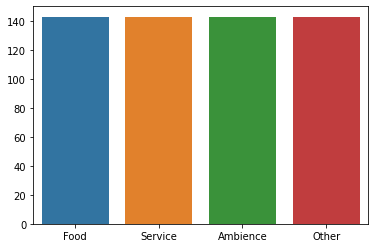

In [27]:
x = ["Food", "Service", "Ambience", "Other"]
y = [len(train_upsampled[train_upsampled.type == 1 ]), len(train_upsampled[train_upsampled.type == 2 ]),  
     len(train_upsampled[train_upsampled.type == 3 ]),  len(train_upsampled[train_upsampled.type == 4 ])]

sns.barplot(x, y)
plt.show()

In [39]:
pipeline_sgd = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', SGDClassifier()),])

pipeline_bnb = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', BernoulliNB()),])

# pipeline_svc = Pipeline([('vect', CountVectorizer()), 
#                          ('tfidf',  TfidfTransformer()), 
#                          ('nb', SVC()),])

pipeline_rfc = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', RandomForestClassifier()),])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train_upsampled['review_text'],
                                                    train_upsampled['type'],
                                                    random_state = 0)
models = []

model_sgd = pipeline_sgd.fit(X_train, y_train)
model_bnb = pipeline_bnb.fit(X_train, y_train)
# model_svc = pipeline_svc.fit(X_train, y_train)
model_rfc = pipeline_rfc.fit(X_train, y_train)

models.append({"name": "model_sgd", "model": model_sgd})
models.append({"name": "model_bnb", "model": model_bnb})
# models.append({"name": "model_svc", "model": model_svc})
models.append({"name": "model_rfc", "model": model_rfc})

In [41]:
for index in range (len(models)):
    print("Model name:", models[index]['name'])
    y_predict = models[index]['model'].predict(X_test)
    f1_score_result = f1_score(y_test, y_predict, average="weighted")
    accuracy_score_result = accuracy_score(y_test, y_predict)
    precision_score_result = precision_score(y_test, y_predict, average="weighted")

    print("F1 score %s" % round(f1_score_result*100, 2), "%")
    print("Accuracy score %s" % round(accuracy_score_result*100, 2), "%")
    print("Precision score %s" % round(precision_score_result*100, 2), "%")
    print("-----------------------")

Model name: model_sgd
F1 score 85.09 %
Accuracy score 85.31 %
Precision score 85.79 %
-----------------------
Model name: model_bnb
F1 score 60.76 %
Accuracy score 64.34 %
Precision score 74.1 %
-----------------------
Model name: model_rfc
F1 score 90.18 %
Accuracy score 90.21 %
Precision score 90.16 %
-----------------------


In [42]:
pickle.dump(models[2]['model'], open("model", 'wb'))

In [43]:
loaded_model = pickle.load(open("model_types", 'rb'))

In [44]:
print(loaded_model)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('nb', RandomForestClassifier())])


In [45]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return text

In [49]:
print(test.size)

150


In [74]:
for i in range (test.size - 1):
    try: 
        review = test.iloc[i]['review_text']
        review = clean_text(review)

        output = ["Food", "Service", "Ambience", "Other"]
        result = loaded_model.predict(pd.Series(review))[0]
        if(result == 3):
            print(review, "<==>", output[int(result)-1])
            print()
    except:
        continue
    